<a href="https://colab.research.google.com/github/FernandoElizarraras7/SIMULACION-II/blob/main/EXTRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LINEAS DE ESPERA EN PARALELO

En muchos sistemas de servicio (aeropuertos, bancos, hospitales, centros de atención), varios servidores atienden en paralelo a una única fila de clientes. Este arreglo se modela clásicamente como *M/M/c* : llegadas *Poisson* (tasa $\lambda$), tiempos de servicio exponenciales (tasa $\mu$ por servidor) y $c$ servidores idénticos atendiendo bajo una disciplina *FCFS*; la fuente y la capacidad de espera suelen asumirse infinitas. Este modelo tiene solución analítica cerrada (fórmulas de *Erlang‑C*) para métricas como la probabilidad de esperar, el número/tiempo promedio en cola y en sistema, y la utilización $\rho$.  
En esta notebook trabajamos el Ejercicio 8 (Aeropuerto Drake): El ejercicio pide dimensionar el número de mostradores $c$ bajo tres restricciones de desempeño (tiempo promedio, ociosidad y probabilidad de ociosidad total). Lo eligió porque:
- Es un problema con datos realistas.  
- Permite aplicar directamente *Erlang‑C* (teoría) y validar con simulación de eventos discretos.

## EJERCICIO 8
El aeropuerto Drake presta servicios a pasajeros, rurales, suburbanos y en tránsito. La distribución de las llegadas de cada uno de los tres grupos es *Poisson* con tasas medias de 15, 10 y 20 pasajeros por hora, respectivamente. El tiempo para documentar un pasajero es exponencial con media de 6 minutos. Determine la cantidad de mostradores que debe haber en Drake en cada una de las siguientes condiciones:

a) El tiempo promedio total para documentar un cliente es de al menos $15$ minutos

b) El procentaje de ocisosidad de los mostradores no excede de $10%$

c) La probabilidad de que todos los mostradores estén ocisosos no excede de $.01$

## Cálculos teóricos (M/M/c con *Erlang‑C*)

Datos del ejercicio:  
Llegadas Poisson por grupo: $15, 10, 20$ psj/h. Al ser independientes, la suma también es Poisson:  

$$\lambda = 15 + 10 + 20 = \mathbf{45\ \text{psj/h}}.
$$  
Tiempo de documentación: exponencial con media 6 minutios $\mu = 10\ \text{pas/h}$ por mostrador.

Modelo: *M/M/c* (FCFS, fuente/cola infinitas). Condición de estabilidad:
$$\rho \;=\; \frac{\lambda}{c\,\mu} \;<\; 1 \quad\Rightarrow\quad c \;>\; \frac{\lambda}{\mu} \;=\; 4.5\ \Rightarrow\ \mathbf{c\ge5}$$

Fórmulas de *Erlang‑C*  
Sea $$a=\lambda/\mu$$ y $$\rho=\lambda/(c\mu)$$
Entonces
$$P_0=\Bigg[\sum_{n=0}^{c-1}\frac{a^n}{n!}+\frac{a^c}{c!\,(1-\rho)}\Bigg]^{-1},\quad P_w=\Pr\{W>0\}=\frac{a^c}{c!\,(1-\rho)}\,P_0, $$
$$ L_q=\frac{P_w\,\rho}{1-\rho},\quad W_q=\frac{L_q}{\lambda},\quad
W=W_q+\frac{1}{\mu},\quad L=\lambda\,W $$

Resultados clave para decidir *c*:
- Para $c=5$: $\rho=0.90$, $W \approx \mathbf{15.15}$ min, $P_0 \approx 0.00496$.
- Para $c=6$: $\rho=0.75$, $W \approx \mathbf{7.69}$ min, $P_0 \approx 0.00914$.

### RESULTADOS TEÓRICOS:
a) “El tiempo promedio total para documentar un cliente es de **al menos** 15 min”.  
  - En metas de servicio, lo usual es “a lo más 15 min (≤ 15)”.  
  - Si interpretamos ≤ 15 min: el mínimo que cumple es $c=6$ (con $c=5$ sale ~15.15 min).  
  - Si tomamos literal ≥ 15 min: bastaría $c=5$, pero esa lectura no es la habitual.

b) El porcentaje de ociosidad no excede de 10% $$1-\rho \le 0.10\ \Rightarrow\ \rho\ge0.90$$  
  Con $$\rho=\frac{45}{10c}$$, el único $c$ estable que cumple es $c=5$.

c)$P_{todos\space ociosos}=P_0 \le 0.01$.  
  Cumplen $c=5$ y $c=6$ (mínimo: $c=5$).

## CÓDIGO DE CÁLCULOS TEÓRICOS



In [15]:
# === CALCULO TEORICO ===
import math
import pandas as pd
import numpy as np

LAMBDA = 45.0  # pas/h
MU     = 10.0  # pas/h por mostrador

def erlang_c_metrics(lmbda: float, mu: float, c: int):
    rho = lmbda/(c*mu)
    if rho >= 1:
        return dict(rho=rho, P0=float("nan"), Pw=float("nan"),
                    Lq=float("inf"), Wq=float("inf"), W=float("inf"), L=float("inf"))
    a = lmbda/mu
    s = sum((a**n)/math.factorial(n) for n in range(c))
    last = (a**c)/(math.factorial(c)*(1-rho))
    P0 = 1.0/(s + last)
    Pw = last*P0
    Lq = (Pw*rho)/(1-rho)
    Wq = Lq/lmbda
    W  = Wq + 1.0/mu
    L  = lmbda*W
    return dict(rho=rho, P0=P0, Pw=Pw, Lq=Lq, Wq=Wq, W=W, L=L)

rows = []
for c in range(5, 13):
    m = erlang_c_metrics(LAMBDA, MU, c)
    rows.append({
        "c": c,
        "rho": m["rho"],
        "P0": m["P0"],
        "Pw": m["Pw"],
        "Lq": m["Lq"],
        "Wq[h]": m["Wq"],
        "W[h]": m["W"],
        "W[min]": m["W"]*60,
        "L": m["L"]
    })

df_teo = pd.DataFrame(rows)
pd.options.display.float_format = "{:,.4f}".format
df_teo
# (a) W ≤ 15 min
cond_a = df_teo["W[min]"] <= 15.0

# (b) ociosidad ≤ 10%  => 1 - rho ≤ 0.10
cond_b = (1.0 - df_teo["rho"]) <= 0.10

# (c) P0 ≤ 0.01
cond_c = df_teo["P0"] <= 0.01

# Listas de c que cumplen cada inciso
cs_a = df_teo.loc[cond_a, "c"].tolist()
cs_b = df_teo.loc[cond_b, "c"].tolist()
cs_c = df_teo.loc[cond_c, "c"].tolist()

print("Inciso (a)  W ≤ 15 min → c que cumplen:", cs_a if cs_a else "Ninguno en el rango evaluado")
print("Inciso (b)  ociosidad ≤ 10% → c que cumplen:", cs_b if cs_b else "Ninguno en el rango evaluado")
print("Inciso (c)  P0 ≤ 0.01 → c que cumplen:", cs_c if cs_c else "Ninguno en el rango evaluado")

# c mínimo que cumple (si existe)
def minimo(lista):
    return min(lista) if len(lista)>0 else None

c_min_a = minimo(cs_a)
c_min_b = minimo(cs_b)
c_min_c = minimo(cs_c)

print("\nMínimos que cumplen:")
print(f" (a) W ≤ 15 min → c_min = {c_min_a}")
print(f" (b) ociosidad ≤ 10% → c_min = {c_min_b}")
print(f" (c) P0 ≤ 0.01 → c_min = {c_min_c}")

# Tabla con PASA/NO PASA por inciso
df_flags = df_teo[["c","rho","P0","W[min]"]].copy()
df_flags["(a) W≤15min"]    = np.where(cond_a, "PASA", "NO PASA")
df_flags["(b) ocioso≤10%"]  = np.where(cond_b, "PASA", "NO PASA")
df_flags["(c) P0≤0.01"]    = np.where(cond_c, "PASA", "NO PASA")

# Formatos para lectura rápida
pd.options.display.float_format = "{:,.6f}".format
df_flags

Inciso (a)  W ≤ 15 min → c que cumplen: [6, 7, 8, 9, 10, 11, 12]
Inciso (b)  ociosidad ≤ 10% → c que cumplen: [5]
Inciso (c)  P0 ≤ 0.01 → c que cumplen: [5, 6]

Mínimos que cumplen:
 (a) W ≤ 15 min → c_min = 6
 (b) ociosidad ≤ 10% → c_min = 5
 (c) P0 ≤ 0.01 → c_min = 5


,c,rho,P0,W[min],(a) W≤15min,(b) ocioso≤10%,(c) P0≤0.01
0,5,0.900000,0.004959,15.149919,NO PASA,PASA,PASA
1,6,0.750000,0.009140,7.686608,PASA,NO PASA,PASA
2,7,0.642857,0.010464,6.521330,PASA,NO PASA,NO PASA
3,8,0.562500,0.010899,6.178096,PASA,NO PASA,NO PASA
4,9,0.500000,0.011042,6.061399,PASA,NO PASA,NO PASA
5,10,0.450000,0.011088,6.020637,PASA,NO PASA,NO PASA
6,11,0.409091,0.011103,6.006658,PASA,NO PASA,NO PASA
7,12,0.375000,0.011107,6.002047,PASA,NO PASA,NO PASA


## CÓDIGO PARA LA SIMULACIÓN

=== c=5 ===
W(sim)  ≈ 14.78 min
W(teo)  ≈ 15.15 min
P0(sim) ≈ 0.0048
rho(sim)≈ 0.8016  (ociosidad≈ 0.1984)
Incisos (Simulación):
 (a) W ≤ 15 min → PASA
 (b) ociosidad ≤ 10% → NO PASA
 (c) P0 ≤ 0.01 → PASA

=== c=6 ===
W(sim)  ≈ 7.66 min
W(teo)  ≈ 7.69 min
P0(sim) ≈ 0.0094
rho(sim)≈ 0.6693  (ociosidad≈ 0.3307)
Incisos (Simulación):
 (a) W ≤ 15 min → PASA
 (b) ociosidad ≤ 10% → NO PASA
 (c) P0 ≤ 0.01 → PASA



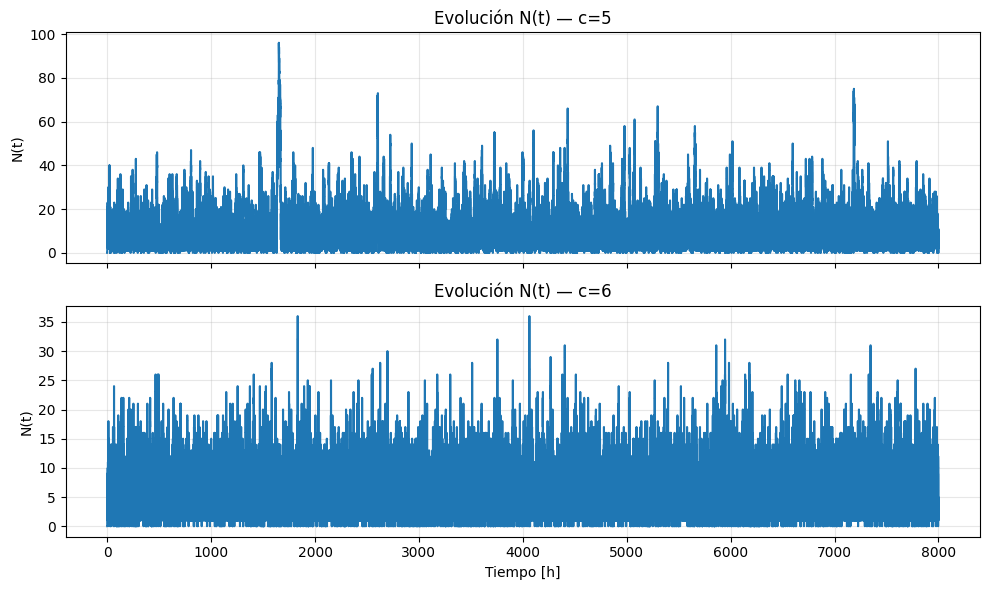

In [21]:
# === LINEA DE ESPERA CON SERVIDORES EN PARALELO ===
!pip install simpy --quiet
import simpy, random, numpy as np
import matplotlib.pyplot as plt

# Parámetros del ejercicio (Aeropuerto Drake)
LAMBDA = 45.0  # pas/h
MU     = 10.0  # pas/h por mostrador

def simulate_mm_c_check(lmbda=45.0, mu=10.0, c=5,
                        T=8000.0, seed=2025,
                        warm_frac=0.05,
                        sample_step=1/12):
    random.seed(seed); np.random.seed(seed)
    env = simpy.Environment()
    res = simpy.Resource(env, capacity=c)

    Tw = warm_frac * T               # Instante de inicio de medición de TIEMPO
    last_t = 0.0                     # Último instante al que integramos
    time_at_N0 = 0.0                 # ∫ 1_{N(t)=0} dt sobre [Tw, T]
    busy_time_integral = 0.0         # ∫ res.count dt sobre [Tw, T]

    n_in_system = 0                  # Número de clientes en sistema (cola+servicio)
    t_trace, n_trace = [], []        # Para graficar N(t)

    # Función para acumular integrales SOLO post warm-up
    def add_interval(now):
        nonlocal last_t, time_at_N0, busy_time_integral
        t0 = max(last_t, Tw)
        t1 = now
        if t1 > t0:
            dt = t1 - t0
            # N(t)=0?
            if n_in_system == 0:
                time_at_N0 += dt
            # Ocupación por tiempo: usar conteo real de servidores ocupados
            busy_time_integral += res.count * dt
        last_t = now

    # Monitoreo N(t) para gráfica
    def monitor(env):
        while True:
            t_trace.append(env.now)
            n_trace.append(n_in_system)
            yield env.timeout(sample_step)

    # Métricas por cliente
    totals = []

    def cliente(env, i):
        nonlocal n_in_system
        # Llegada
        add_interval(env.now)
        n_in_system += 1
        t_arr = env.now

        with res.request() as req:
            yield req
            # Entra a servicio
            add_interval(env.now)
            st = random.expovariate(mu)
            yield env.timeout(st)

        # Salida
        add_interval(env.now)
        n_in_system -= 1

        totals.append(env.now - t_arr)

    def generador(env):
        i = 0
        while True:
            inter = random.expovariate(lmbda)
            yield env.timeout(inter)
            i += 1
            env.process(cliente(env, i))

    env.process(generador(env))
    env.process(monitor(env))
    env.run(until=T)

    # Métricas por cliente (post warm-up por clientes)
    cut = int(len(totals) * warm_frac)
    W_sim_h  = float(np.mean(totals[cut:])) if len(totals) > cut else float('nan')
    W_sim_min = W_sim_h * 60.0

    # Métricas por TIEMPO (post warm-up)
    window = T - Tw
    P0_sim   = time_at_N0 / window if window > 0 else float('nan')
    rho_sim  = (busy_time_integral / window) / c if window > 0 else float('nan')

    return {
        "W_sim_min": W_sim_min,
        "W_sim_h": W_sim_h,
        "P0_sim": P0_sim,
        "rho_sim": rho_sim,
        "trace": (t_trace, n_trace)
    }

# Ejecutar y mostrar resultados con verificación de incisos
def check_and_print(c, W_teo_min=None, tol_idle=0.0005, T=8000.0, seed=2025):
    out = simulate_mm_c_check(lmbda=LAMBDA, mu=MU, c=c, T=T, seed=seed)
    W_sim_min = out["W_sim_min"]
    P0_sim    = out["P0_sim"]
    rho_sim   = out["rho_sim"]

    # Incisos:
    pass_a = (W_sim_min <= 15.0)                 # (a) W ≤ 15 min
    pass_b = ((1.0 - rho_sim) <= 0.10 + tol_idle)# (b) Ociosidad ≤ 10% (con pequeña tolerancia)
    pass_c = (P0_sim <= 0.01)                    # (c) P0 ≤ 0.01

    print(f"=== c={c} ===")
    print(f"W(sim)  ≈ {W_sim_min:.2f} min")
    if W_teo_min is not None:
        print(f"W(teo)  ≈ {W_teo_min:.2f} min")
    print(f"P0(sim) ≈ {P0_sim:.4f}")
    print(f"rho(sim)≈ {rho_sim:.4f}  (ociosidad≈ {1-rho_sim:.4f})")
    print("Incisos (Simulación):")
    print(f" (a) W ≤ 15 min → {'PASA' if pass_a else 'NO PASA'}")
    print(f" (b) ociosidad ≤ 10% → {'PASA' if pass_b else 'NO PASA'}")
    print(f" (c) P0 ≤ 0.01 → {'PASA' if pass_c else 'NO PASA'}")
    print()
    return out

# ====== LLAMADAS (¡esto es lo que faltaba!) ======
# (Opcional) W teóricos por claridad
W_teo_c5_min = 15.1519
W_teo_c6_min = 7.6866

# Ejecuta y muestra resultados (imprime a consola)
out5 = check_and_print(c=5, W_teo_min=W_teo_c5_min, T=8000.0, seed=2025)
out6 = check_and_print(c=6, W_teo_min=W_teo_c6_min, T=8000.0, seed=2026)

# ====== Gráficas N(t) (opcional) ======
fig, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)
for ax, c, out in zip(axes, [5,6], [out5, out6]):
    t, n = out["trace"]
    ax.step(t, n, where='post')
    ax.set_title(f"Evolución N(t) — c={c}")
    ax.set_ylabel("N(t)")
    ax.grid(alpha=0.3)
axes[-1].set_xlabel("Tiempo [h]")
plt.tight_layout()
plt.show()

## CONCLUSIONES
* El sistema de mostradores en paralelo se modela correctamente como *M/M/c; con $\lambda=45$ psj/h y $\mu=10$ psj/h, la teoría de *Erlang‑C* entrega métricas cerradas y confiables.
* Para la meta práctica $W \le 15$ min, el mínimo que cumple es $c=6$ ($≈ 7.7$ min); con $c=5$ se obtiene $≈ 15.15$ min, ligeramente por encima del umbral.
* El requisito de ociosidad $\le 10\%$ se satisface con $c=5$ ($\rho=0.90$); el de $P_0 \le 0.01$ lo cumplen $c=5$ y $c=6$, siendo $c=5$ el mínimo.
* La simulación reproduce los valores teóricos y confirma el comportamiento esperado; discrepancias pequeñas se deben a azar, horizonte finito y necesidad de *warm‑up*.
* En algunos corridos, con $c=5$ la ociosidad simulada puede salir $>10%$ y marcar “NO PASA” por sesgo de arranque y variación muestral; con *warm‑up* post‑tiempo y réplicas converge al $10%$ teórico.

